# HW3 Image Classification

https://www.kaggle.com/c/ml2022spring-hw3b/code?competitionId=34954&sortBy=dateCreated

# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [ ]:
! wget https://www.dropbox.com/s/6l2vcvxl54b0b6w/food11.zip
# ! wget -O food11.zip "https://github.com/virginiakm1988/ML2022-Spring/blob/main/HW03/food11.zip?raw=true"

In [ ]:
! unzip food11.zip

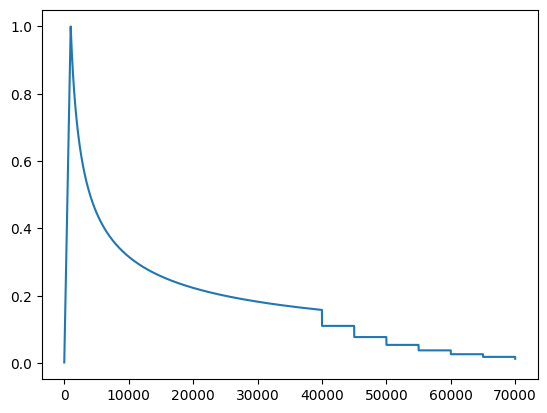

In [15]:
import matplotlib.pyplot as plt
import math

num_warmup_steps = 1000
num_training_steps = 70000
decay_const = 2.5

def lr_lambda_exp(current_step):
		# Warmup
		if current_step < num_warmup_steps:
			return float(current_step) / float(max(1, num_warmup_steps))
		# decadence
		progress = float(current_step - num_warmup_steps) / float(
			max(1, num_training_steps - num_warmup_steps)
		)
		return max(
			0.0, math.exp(-decay_const * progress)
		)

num_cycles = 0.425

def lr_lambda_sin(current_step):
		# Warmup
		if current_step < num_warmup_steps:
			return float(current_step) / float(max(1, num_warmup_steps))
		# decadence
		progress = float(current_step - num_warmup_steps) / float(
			max(1, num_training_steps - num_warmup_steps)
		)
		return max(
			0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
		)

switch_to_milestone_steps = 40000
milestones = 5000
milestones_decay = 0.7

def transform_lr(current_step):
	if current_step < switch_to_milestone_steps:
		step = current_step + 1
		return min(step**(-0.5), step * num_warmup_steps**(-1.5)) / num_warmup_steps**(-0.5)
	else:
		return switch_to_milestone_steps**(-0.5) / num_warmup_steps**(-0.5) * (milestones_decay ** ((current_step - switch_to_milestone_steps)//milestones + 1))
	    # return switch_to_milestone_steps**(-0.5)/ num_warmup_steps**(-0.5)


x = [i for i in range(70000)]
y1 = [lr_lambda_exp(i) for i in x]
y2 = [lr_lambda_sin(i) for i in x]
y3 = [transform_lr(i + 1) for i in x]

# plt.plot(x, y1)
# plt.plot(x, y2)
plt.plot(x, y3)

In [6]:
# Setup

#######################################################
# Import necessary packages.
#######################################################

import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
import pytorch_warmup as warmup
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset, IterableDataset
from torchvision.datasets import DatasetFolder, VisionDataset
from torch.utils.tensorboard import SummaryWriter

# This is for the progress bar.
from tqdm import tqdm
import random
import datetime
import signal, sys
from contextlib import AbstractContextManager

myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)
    print("Cuda is available")


#######################################################
# Transforms (data augmentations)
#######################################################

# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    
    # You may add some transforms here.
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.01, 5)),
    # transforms.RandomPerspective(distortion_scale=0.6, p=0.2),
    # transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.2),
    # transforms.RandomAutocontrast(p=0.2),
    # transforms.RandomEqualize(p=0.2),

    transforms.RandomChoice([
        transforms.AutoAugment(policy) for policy in [
            transforms.AutoAugmentPolicy.CIFAR10,
            transforms.AutoAugmentPolicy.IMAGENET,
            transforms.AutoAugmentPolicy.SVHN
        ]
    ]),
    
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])


#######################################################
# Dataset
#######################################################

class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = np.array(sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")]))
        if files != None:
            self.files = np.array(files)
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        #im = self.data[idx]
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im,label


#######################################################
# Network
#######################################################

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

model = Classifier()

#######################################################
# Dataloader
#######################################################

batch_size = 64
_dataset_dir = "./food11"
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset(os.path.join(_dataset_dir,"training"), tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)

valid_set = FoodDataset(os.path.join(_dataset_dir,"validation"), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)

valid_set_arg = FoodDataset(os.path.join(_dataset_dir,"validation"), tfm=train_tfm)
valid_arg_loader = DataLoader(valid_set_arg, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)


#######################################################
# Trainer
#######################################################

def train(loader, model, criterion, optimizer, scheduler, warmup_scheduler, device):

    train_losses = []
    train_accs = []
    train_grad_norms = []

    lr = optimizer.param_groups[0]['lr']

    for imgs, labels in tqdm(loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = imgs.to(device), labels.to(device)
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = logits.argmax(dim=-1).eq_(labels).float().mean()

        # Record the loss and accuracy.
        train_losses.append(loss.item())
        train_accs.append(acc)
        train_grad_norms.append(grad_norm)
        with warmup_scheduler.dampening():
            pass

    with warmup_scheduler.dampening():
        scheduler.step()
        
    train_loss = sum(train_losses) / len(train_losses)
    train_acc = sum(train_accs) / len(train_accs)
    train_grad_norm = sum(train_grad_norms) / len(train_grad_norms)

    return train_loss, train_acc, train_grad_norm, lr


#######################################################
# Validation
#######################################################

def validate(loader, model, criterion, optimizer, device):
    
    valid_losses = []
    valid_accs = []

    # Iterate the validation set by batches.
    for imgs, labels in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = imgs.to(device), labels.to(device)
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = logits.argmax(dim=-1).eq_(labels).float().mean()

        # Record the loss and accuracy.
        valid_losses.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_losses) / len(valid_losses)
    valid_acc = sum(valid_accs) / len(valid_accs)

    return valid_loss, valid_acc


#######################################################
# Logging
#######################################################

def log(msg, toFile=True):
    global _exp_name
    # print(msg)
    if toFile:
        with open(f"./{_exp_name}.log","a") as f:
            f.write(f"{msg}\n")

class TensorBoardWriter(AbstractContextManager):
    def __init__(self, *args, **kwargs):

        comment = kwargs.get("comment", None)

        if comment == "test" or comment is None:
            self.writer = SummaryWriter("runs/test")
        else:
            kwargs["comment"] = f"/{comment}"
            self.writer = SummaryWriter(*args, **kwargs)

    def __enter__(self):
        return self.writer

    def __exit__(self, *args):
        print("Closing TensorBoard writer...")
        self.writer.close()

Cuda is available
One ./food11/training sample ./food11/training/0_0.jpg
One ./food11/validation sample ./food11/validation/0_0.jpg
One ./food11/validation sample ./food11/validation/0_0.jpg


In [2]:
# ResNet-18

from torchvision.models import resnet18

model_resnet18 = resnet18(weights=None)
model_resnet18.fc = nn.Sequential(
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 11)
)

In [7]:
# 8-layer-CNN-Res

class Residual(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.cov = nn.Conv2d(dim, dim, 3, 1, 1, bias=False)
        self.norm = nn.BatchNorm2d(dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        x = self.cov(x)
        x = self.norm(x)
        x = x + residual
        x = self.relu(x)
        return x


class Convolutional(nn.Module):
    # shape_in = (dim_in, H, W) -> shape_out = (dim_out, H/2, W/2)
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, 3, 1, 1, bias=False),    # [dim_out, H, W]
            nn.BatchNorm2d(dim_out),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0)                   # [dim_out, H/2, W/2]
        )

    def forward(self, x):
        return self.cnn(x)
        
class Residual_Network(nn.Module):
    def __init__(self):
        super().__init__()

        # input shape [3, 128, 128]
        self.cnn = nn.Sequential(
            Convolutional(3, 64),       # [64, 64, 64]
            Residual(64),
            Convolutional(64, 128),     # [128, 32, 32]
            Residual(128),
            Convolutional(128, 256),    # [256, 16, 16]
            Residual(256),
            Convolutional(256, 512),    # [512, 8, 8]
            Convolutional(512, 512),    # [512, 4, 4]

        )
        self.fc = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

model_8_layer_rnn = Residual_Network()

In [4]:
# 11-layer-CNN-Res

class Residual(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.cov1 = nn.Conv2d(dim, dim, 3, 1, 1)
        self.norm1 = nn.BatchNorm2d(dim)
        self.relu1 = nn.ReLU()
        self.cov2 = nn.Conv2d(dim, dim, 3, 1, 1)
        self.norm2 = nn.BatchNorm2d(dim)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        residual = x
        x = self.cov1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.cov2(x)
        x = self.norm2(x)
        x = x + residual
        x = self.relu2(x)
        return x

class Convolutional(nn.Module):
    # shape_in = (dim_in, H, W) -> shape_out = (dim_out, H/2, W/2)
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, 3, 1, 1),    # [dim_out, H, W]
            nn.BatchNorm2d(dim_out),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0)                   # [dim_out, H/2, W/2]
        )

    def forward(self, x):
        return self.cnn(x)
        
class Residual_Network(nn.Module):
    def __init__(self):
        super().__init__()

        # input shape [3, 128, 128]
        self.cnn = nn.Sequential(
            Convolutional(3, 64),       # [64, 64, 64]
            Residual(64),
            Convolutional(64, 128),     # [128, 32, 32]
            Residual(128),
            Convolutional(128, 256),    # [256, 16, 16]
            Residual(256),
            Convolutional(256, 512),    # [512, 8, 8]
            Convolutional(512, 512),    # [512, 4, 4]

        )
        self.fc = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

model = Residual_Network()

In [9]:
# Print network summary

model_to_print = model_resnet18

print(model_to_print)
total_params = sum(p.numel() for p in model_to_print.parameters())
total_params_trainable = sum(p.numel() for p in model_to_print.parameters() if p.requires_grad)
print(f"{total_params} parameters, {total_params_trainable} trainable.")


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# Cross Validation - Ensemble

sets_num = 5

labeled_set = ConcatDataset([train_set, valid_set])

set_len = len(labeled_set)//5

labeled_sets = [Subset(labeled_set, np.arange(set_len * i, set_len * i + 1)) for i in range(sets_num)]

print(len(labeled_set), set_len*5)


13296 13295


In [8]:
# Training function

def run(exp_name, model, n_epochs, patience=150, load_model=False, load_model_path=None, start_from_epoch=0, opti="Adam", learning_rate=0.001, milestone_num=0):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    log(f"\n{datetime.datetime.now()} started new training...\n")
    model = model.to(device)

    if load_model:
        model_path = load_model_path or f"{exp_name}.ckpt"
        model.load_state_dict(torch.load(model_path))
        log(f"Continue with exsisted model '{model_path}'")
    else:
        open(f"./{exp_name}.log", "w").close()

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    if opti == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    elif opti == "SGDM":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8, weight_decay=1e-5)
    
    if milestone_num == 0:
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=n_epochs, gamma=1)
    else:
        milestone_epochs = n_epochs - start_from_epoch
        milestones = list(range(milestone_epochs//milestone_num , milestone_epochs, milestone_epochs//milestone_num))
        print(f"Milestones: {milestones}")
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.56)

    if opti == "Adam":
        warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)
    elif opti == "SGDM":
        warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period=155*10)

    stale = 0
    best_acc = 0
    best_epoch = 0

    with TensorBoardWriter(comment=exp_name) as writer:
        for epoch in range(start_from_epoch, n_epochs):
            model.train()
            train_loss, train_acc, train_grad_norm, lr = train(train_loader, model, criterion, optimizer, scheduler, warmup_scheduler, device)
            log(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

            model.eval()
            valid_loss, valid_acc = validate(valid_loader, model, criterion, optimizer, device)
            log(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}{' -> best' if valid_acc > best_acc else ''}")

            writer.add_scalars('loss', {
                    'train_loss': train_loss,
                    'valid_loss': valid_loss,
                }, epoch + 1)

            writer.add_scalars('acc', {
                    'train_acc': train_acc,
                    'valid_acc': valid_acc,
                }, epoch + 1)

            writer.add_scalar('train_grad_norm', train_grad_norm, epoch + 1)
            writer.add_scalar('learning_rate', lr, epoch + 1)

            if valid_acc > best_acc:
                log(f"Best model so far, saving model", toFile=False)
                torch.save(model.state_dict(), f"{exp_name}.ckpt")
                best_acc = valid_acc
                best_epoch = epoch
                stale = 0
            else:
                stale += 1
                if stale > patience:
                    log(f"No improvment {patience} consecutive epochs, early stopping")
                    break

    print(f"Best model found at epoch {best_epoch + 1:03d} of {n_epochs:03d}.")

    log(f"{datetime.datetime.now()} finished training. Best model found at epoch {best_epoch + 1:03d} of {n_epochs:03d}.")

In [9]:
# run(exp_name, model, n_epochs, patience=150, load_model=False, load_model_path=None, start_from_epoch=0, opti="Adam")

# _exp_name = "auto_aug_re-8-layer-CNN_Res_LS_lr-warmup-scheduler_lr=0.00132_300"
# n_epochs = 300
# config = {
#     # "patience": 150, 
#     # "load_model": False,
#     # "load_model_path": None,
#     # "start_from_epoch": 0,
#     "opti": "Adam",
#     "learning_rate": 0.00132,
#     "milestone_num": 10
# }
# run(_exp_name, model_8_layer_rnn, n_epochs, **config)


_exp_name = "auto_aug_re-8-layer-CNN_Res_LS_lr-warmup-scheduler_lr=0.00132_300_SDGM-lr=0.02"
# _exp_name = "test"
n_epochs = 450

config = {
    "patience": 50, 
    "load_model": True,
    "load_model_path": "./auto_aug_re-8-layer-CNN_Res_LS_lr-warmup-scheduler_lr=0.00132_300.ckpt",
    "start_from_epoch": 300,
    "opti": "SGDM",
    "learning_rate": 0.0125,
    "milestone_num": 5
}

run(_exp_name, model_8_layer_rnn, n_epochs, **config)




Milestones: [30, 60, 90, 120]


100%|██████████| 54/54 [00:02<00:00, 19.36it/s]

Closing TensorBoard writer...
Best model found at epoch 340 of 450.


In [ ]:
start_from_epoch = None
load_model_path = None

_exp_name = "auto_aug_re-8-layer-CNN_Res_LS_SDGM-lr=0.01"
load_model = True
load_model_path = "./auto_aug_re-8-layer-CNN_Res_LS_best.ckpt"
start_from_epoch = 749

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

try:
    writer = None
except NameError:
    pass

writer = SummaryWriter(comment=f"/{_exp_name}")

# The number of training epochs and patience.
n_epochs = 1000
patience = 150 # If no improvement in 'patience' epochs, early stop

log(f"\n{datetime.datetime.now()} started new training...\n")

# Initialize a model, and put it on the device specified.
model = model.to(device)

if load_model:
    model_path = load_model_path or f"{_exp_name}_best.ckpt"
    model.load_state_dict(torch.load(model_path))
    log(f"Continue with exsisted model '{model_path}'")
else:
    open(f"./{_exp_name}.log", "w").close()

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8, weight_decay=1e-4) 

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0
best_epoch = 0

start_from_epoch = start_from_epoch - 1 if start_from_epoch is not None else 0

for epoch in range(start_from_epoch - 1, n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()
    train_loss, train_acc = train(train_loader, model, criterion, optimizer, device)

    # Print the information.
    log(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    valid_loss, valid_acc = validate(valid_loader, model, criterion, optimizer, device)

    # Print the information.
    log(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}{' -> best' if valid_acc > best_acc else ''}")

    writer.add_scalars('status/loss', {
            'train_loss': train_loss,
            'valid_loss': valid_loss,
        }, epoch + 1)

    writer.add_scalars('status/acc', {
            'train_acc': train_acc,
            'valid_acc': valid_acc,
        }, epoch + 1)

    # save models
    if valid_acc > best_acc:
        log(f"Best model so far, saving model", toFile=False)
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        best_epoch = epoch
        stale = 0
    else:
        stale += 1
        if stale > patience:
            log(f"No improvment {patience} consecutive epochs, early stopping")
            break
            
print(f"Best model found at epoch {best_epoch + 1:03d} of {n_epochs:03d}.")   

log(f"{datetime.datetime.now()} finished training. Best model found at epoch {best_epoch + 1:03d} of {n_epochs:03d}.")

writer.close()


In [10]:
test_set = FoodDataset(os.path.join(_dataset_dir,"test"), tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

One ./food11/test sample ./food11/test/0001.jpg


# Testing and generate prediction CSV

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

_exp_name = "auto_aug_re-8-layer-CNN_Res_LS_lr-warmup-scheduler_lr=0.00132_300"
model = model_8_layer_rnn

model_best = model.to(device)
# model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.load_state_dict(torch.load(f"{_exp_name}.ckpt"))

model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in test_loader:
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

In [12]:
#create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(1,len(test_set)+1)]
df["Category"] = prediction
df.to_csv(f"submission-{_exp_name}.csv",index = False)

# Q1. Augmentation Implementation
## Implement augmentation by finishing train_tfm in the code with image size of your choice. 
## Directly copy the following block and paste it on GradeScope after you finish the code
### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times.
### Your  train_tfm in the report can be different from train_tfm in your training code.


In [ ]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You need to add some transforms here.
    transforms.ToTensor(),
])

# Q2. Residual Implementation
![](https://i.imgur.com/GYsq1Ap.png)
## Directly copy the following block and paste it on GradeScope after you finish the code


In [ ]:
from torch import nn
class Residual_Network(nn.Module):
    def __init__(self):
        super(Residual_Network, self).__init__()
        
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
        )

        self.cnn_layer4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
        )
        self.cnn_layer5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
        )
        self.cnn_layer6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(256* 32* 32, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x1 = self.cnn_layer1(x)
        
        x1 = self.relu(x1)
        
        x2 = self.cnn_layer2(x1)
        
        x2 = self.relu(x2)
        
        x3 = self.cnn_layer3(x2)
        
        x3 = self.relu(x3)
        
        x4 = self.cnn_layer4(x3)
        
        x4 = self.relu(x4)
        
        x5 = self.cnn_layer5(x4)
        
        x5 = self.relu(x5)
        
        x6 = self.cnn_layer6(x5)
        
        x6 = self.relu(x6)
        
        # The extracted feature map must be flatten before going to fully-connected layers.
        xout = x6.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        xout = self.fc_layer(xout)
        return xout